# Interpolation

In [3]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl        # plotting

import sys # system library
sys.path.append('./lib_nn') 

from neural import * # import my library package

## Simulated data

So far we have been concerned with **classification**, i.e. with networks recognizing whether a given object (in our examples a point on a plane) has certain features. Now we pass to another practical application, namely **interpolating functions**. This use of ANNs has become widely popular in scientific data analyses. We illustrate the method on a simple example, which explains the basic idea and shows how the method works.

Imagine you have some experimental data. Here we simulate them in an artificial way, e.g.

In [4]:
def fi(x):
    return 0.2+0.8*np.sin(x)+0.5*x-3 # a function

def data(): 
    x = 7.*np.random.rand() # random x coordinate
    y = fi(x)+0.4*func.rn() # y coordinate = the function value + noise from [-0.2,0.2]
    return [x,y]

We should now think in terms of supervised learning: $x$ is the "feature", and $y$ is the "label".

We table our noisy data points and plot them together with the function **fi(x)** around which they fluctuate. It is an imitation of an experimental measurement, which is always burdened with some error, here mimicked with a random noise.

In [5]:
tab=np.array([data() for i in range(200)])    # data sample
features=np.delete(tab,1,1)                   # x coordinate
labels=np.delete(tab,0,1)                     # y coordinate

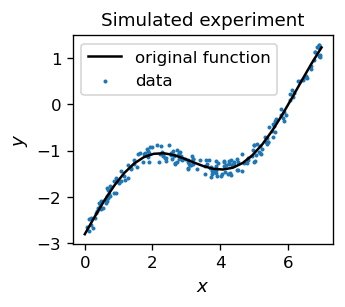

In [6]:
plt.figure(figsize=(2.8,2.3),dpi=120)

coo=np.linspace(0,7,25)

exact=[fi(x) for x in coo]

plt.plot(coo,exact,c='black',label='original function')

plt.title("Simulated experiment",fontsize=11) 
plt.scatter(features,labels,s=2,label='data')

plt.legend(prop={'size':10})

plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11);

In our language of ANNs, we therefore have a training sample consisting of points with the input (feature) $x$ and the true output (label) $y$. As before, we minimize the error function from an appropriate neural network,

$$E(\{w \}) = \sum_p (y_o^{(p)} - y^{(p)})^2. $$

Since the generated $y_o$ is a certain (weight-dependent) function of $x$, this method is a variant of the **least squares fit**, commonly used in data analysis. The difference is that in the standard least squares method the model function that we fit to the data has some simple analytic form (e.g. $ f(x) = A + B x$), whereas now it is some "disguised" weight-dependent function provided by the neural network.

## ANNs for interpolation

To understand the fundamental idea, consider a network with just two neurons in the middle layer, with the sigmoid activation function:

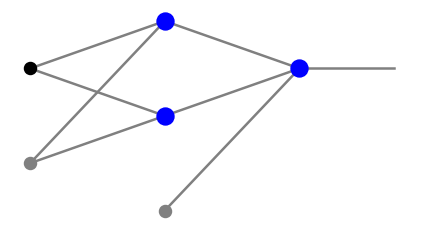

In [7]:
draw.plot_net([1,2,1]);

The signals entering the two neurons in the middle layer are, in the notation of chapter {ref}`more-lab`,

$$s_1^{1}=w_{01}^{1}+w_{11}^{1} x, $$

$$s_2^{1}=w_{02}^{1}+w_{12}^{1} x, $$

and the outgoing signals are, correspondingly,

$$\sigma \left( w_{01}^{1}+w_{11}^{1} x \right), $$

$$\sigma \left( w_{02}^{1}+w_{12}^{1} x \right). $$

Therefore the combined signal entering the output neuron is 

$$s_1^{1}=w_{01}^{2}+ w_{11}^{2}\sigma \left( w_{01}^{1}+w_{11}^{1} x \right)
+  w_{21}^{2}\sigma \left( w_{02}^{1}+w_{12}^{1} x \right). $$ 

Taking, for illustration, the sample weight values 

$$w_{01}^{2}=0, \, w_{11}^{2}=1, \, w_{21}^{2}=-1, \,
w_{11}^{1}=w_{12}^{1}=1, \, w_{01}^{1}=-x_1,  \, w_{02}^{1}=-x_2, $$

where $x_1$ and $x_2$ is a short-hand notation, we get 

$s_1^{1}=\sigma(x-x_1)-\sigma(x-x_2)$.

This function is shown in the plot below, with $x_1=-1$ and $x_2=4$. 
It tends to 0 at $- \infty$, then grows with $x$ to achieve a maximum at
$(x_1+x_2)/2$, and then decreases, tending to 0 at $+\infty$. At $x=x_1$ and $x=x_2$, the values are around 0.5, so one can say that the span of the function is between $x_1$ and $x_2$.

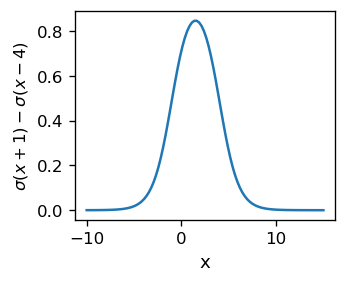

In [9]:
plt.figure(figsize=(2.8,2.3),dpi=120)

s = np.linspace(-10, 15, 100)

fs = [func.sig(z+1)-func.sig(z-4) for z in s]

plt.xlabel('x',fontsize=11)
plt.ylabel('$\sigma(x+1)-\sigma(x-4)$',fontsize=10)

plt.plot(s, fs);

This is a straightforward but important finding:
We are able to form, with a pair of neurons with sigmoids, a "hump" signal located around a given value, here $ (x_1 + x_2) / 2 = 2$, and with a a given spread of the order of $|x_2-x_1|$. Changing the weights, we are able to modify its shape, width, and height.

One may now think as follows: Imagine we have many neurons to our disposal in the intermediate layer. We can join them in pairs, forming humps "specializing" in particular regions of coordinates. Then, adjusting the heights of the humps, we can readily approximate a given function. 

In an actual fitting procedure, we do not need to "join the neurons in pairs", but make a combined fit of all the parameters simultaneously, as we did in the case of classifiers. The example below shows a composition of 8 sigmoids,

$$
f = \sigma(z+3)-\sigma(z+1)+2 \sigma(z)-2\sigma(z-4)+
      \sigma(z-2)-\sigma(z-8)-1.3 \sigma(z-8)-1.3\sigma(z-10). 
$$

In the figure, the component functions (the thin lines representing single humps) add up to a function of a rather complicated shape, marked with a thick line. 

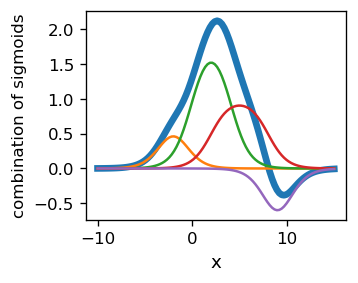

In [7]:
plt.figure(figsize=(2.8,2.3),dpi=120)

s = np.linspace(-10, 15, 100)

f1 = [func.sig(z+3)-func.sig(z+1) for z in s]
f2 = [2*(func.sig(z-0)-func.sig(z-4)) for z in s]
f3 = [func.sig(z-2)-func.sig(z-8) for z in s]
f4 = [-1.3*(func.sig(z-8)-func.sig(z-10)) for z in s]

fs = [func.sig(z+3)-func.sig(z+1)+2*(func.sig(z-0)-func.sig(z-4))+
      func.sig(z-2)-func.sig(z-8)-1.3*(func.sig(z-8)-func.sig(z-10)) 
       for z in s]

plt.xlabel('x',fontsize=11)
plt.ylabel('combination of sigmoids',fontsize=10)

plt.plot(s, fs, linewidth=4)
plt.plot(s, f1)
plt.plot(s, f2)
plt.plot(s, f3)
plt.plot(s, f4);


```{note}

If the fitted function is regular, one expects that it can be approximated with a linear combination of sigmoids. With more sigmoids, a better accuracy can be accomplished.
```

There is an important difference in ANNs used for function approximation compared to the binary classifiers discussed earlier. There, the answers were 0 or 1, so we were using a step activation function in the output layer, or rather its smooth sigmoid variant. For function approximation, the answers typically form a continuum in the range of the function values. For that reason, in the output layer we just use the **identity** function, i.e., we just pass the incoming signal through. Of course, sigmoids remain to operate in the intermediate layers. Then, the formulas used for backprop are those from section {ref}`bpa-lab`, with $f_l(s)=s$ in the output layer. 

```{admonition} Output layer for function approximation
:class: important

In ANNs used for function approximation, the activation function in the output layer is **linear**.
```

### Backprop for one-dimensional functions

Let us take the architecture:

In [10]:
arch=[1,6,1]

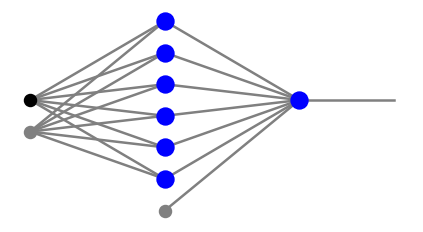

In [11]:
draw.plot_net(arch);

and the random weights

In [12]:
weights=func.set_ran_w(arch, 5)

As just discussed, the output is no longer between 0 and 1, as we can see below.

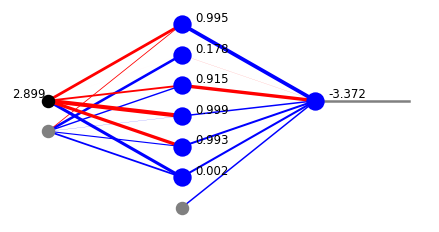

In [11]:
x=func.feed_forward_o(arch, weights,features[1],ff=func.sig,ffo=func.lin)
draw.plot_net_w_x(arch, weights,1,x);

In the library module **func** we have the function for the backprop algorithm which allows for one activation function in the intermediate layers (we take sigmoid) and a different one in the output layer (we take the identity function). The training is carried out in two stages: First, we take the points from the training sample in a random order, and than we sweep over all the points sequentially, also decreasing the learning speed in subsequent rounds. This strategy is one of many, but here it nicely does the job:

In [13]:
eps=0.02                           # initial learning speed
for k in range(30):                # rounds
    for p in range(len(features)): # loop over the data sample points
        pp=np.random.randint(len(features)) # random point
        func.back_prop_o(features,labels,pp,arch,weights,eps,
                         f=func.sig,df=func.dsig,fo=func.lin,dfo=func.dlin)

In [14]:
for k in range(400):               # rounds
    eps=0.999*eps                  # dicrease of the learning speed
    for p in range(len(features)): # loop over points taken in sequence
        func.back_prop_o(features,labels,p,arch,weights,eps,
                         f=func.sig,df=func.dsig,fo=func.lin,dfo=func.dlin)

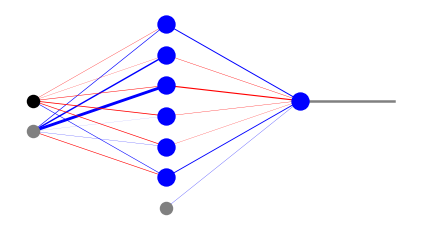

In [14]:
draw.plot_net_w(arch,weights,.2);

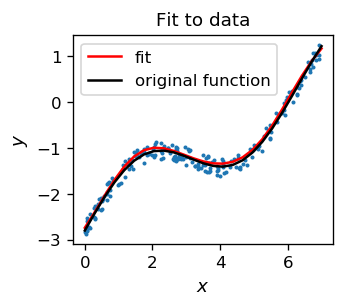

In [15]:
res=[func.feed_forward_o(arch, weights, [x], ff=func.sig, ffo=func.lin)[2][0] for x in coo]

plt.figure(figsize=(2.8,2.3),dpi=120)

plt.title("Fit to data",fontsize=11) 
plt.scatter(features,labels,s=2)


plt.plot(coo,res,c='red',label='fit')
plt.plot(coo,exact,c='black',label='original function')

plt.legend(prop={'size':10})

plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11);

We note that the obtained red curve is very close to the function used to generate the data sample (black line). This shows that the approximation works. A construction of a quantitative measure (least square sum) is a topic of an exercise.

```{note}

The activation function in the output layer may be any smooth function with values containing the values of the interpolated function, not necessarily linear. 

```{admonition} More dimensions
:class: important

To interpolate general functions of two or more arguments, one needs use ANNs with at least 3 neuron layers.
```
We may understand this as follows {cite}`muller2012neural`: Two neurons in the first neuron layer can form a hump in the $x_1$-coordinate, two other ones a hump in the $x_2$-coordinate, and so on for all the dimensions $n$. Taking a conjunction of these $n$ humps in the second neuron layer yields a "basis" function specializing in a region around a certain point in the input space. A sufficiently large number of such basis functions can be used for approximating in $n$ dimensions, in full analogy to the one-dimensional case.

```{tip} 
The number of neurons needed in the procedure reflects the behavior of the interpolated function. If the function varies a lot, one needs more neurons. In one dimension, typically, at least twice as many as the number of extrema of the function.
```

```{admonition} Overfitting
:class: important

There must be much more data for fitting than the network parameters, to avoid the so-called **overfitting problem**. Otherwise we could fit the data with a function "fluctuating from point to point". 
```

## Exercises

```{admonition} $~$
:class: warning

1. Fit the data points generated by your favorite function (of one variable) with noise. Play with the network architecture and draw conclusions.

2. Compute the sum of squared distances between the values of the data points and the corresponding approximating function, and use it as a measure of the goodness of the fit. Test how the number of neurons in the network affects the result. 

3. Use a network with more layers (at least 3 neuron layers) to fit the data points generated with your favorite two-variable function. Make two-dimensional contour plots for this function and for the function obtained from the neural network and compare the results (of course, they should similar if everything works).
```